In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import null_space
import random

In [2]:
data = loadmat('data/compEx2data.mat')
K = data['K']

In [3]:
def normalize_points(points, K):
    K_inv = np.linalg.inv(K)
    normalized_points = K_inv @ points
    return normalized_points

def enforce_essential(E_approx):
    U, S, Vt = np.linalg.svd(E_approx)
    S = np.array([1,1,0])
    E = U @ np.diag(S) @ Vt
    return E


def estimate_E_DLT(x1s, x2s,K, norm=True):
    if norm == True:
        x1n = normalize_points(x1s,K)
        x2n = normalize_points(x2s,K)
    else:
        x1n = x1s
        x2n = x2s
    
    M = []
    for i in range(x1n.shape[1]):
        x1, y1, _ = x1n[:, i]
        x2, y2, _ = x2n[:, i]
        M.append([x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1])
    M = np.array(M)

    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1]
    E_approx = v.reshape(3, 3)

    min_singular_value = S[-1]
    residual = np.linalg.norm(M @ v)
    
    E = enforce_essential(E_approx)
    
    return E

def compute_point_to_line_distances(l, x):
    l1 = l[0,:]
    l2 = l[1,:]
    l3 = l[2,:]
    x1 = x[0,:]
    x2 = x[1,:]
    
    numerator = np.abs(l1*x1 + l2*x2 + l3)
    denominator = np.sqrt(l1**2 + l2**2)
    distances = numerator / denominator
    
    return distances

def compute_rms_error(F, x1s, x2s):
    l1 = F.T @ x2s
    l2 = F @ x1s
    d1 = compute_point_to_line_distances(l1,x1s)
    d2 = compute_point_to_line_distances(l2,x2s)
    rms_error = np.sqrt((np.sum(d1**2) + np.sum(d2**2)) / (2 * x1s.shape[1]))
    return rms_error


def estimate_E_robust(x1, x2, K, eps, max_iterations=500000):
    x1n = normalize_points(x1, K)
    x2n = normalize_points(x2, K)

    best_inliers = None
    best_E = None
    max_inliers = 0

    for _ in range(max_iterations):
        indices = np.random.choice(x1n.shape[1], 8, replace=False)
        x1_sample = x1n[:, indices]
        x2_sample = x2n[:, indices]

        E_candidate = estimate_E_DLT(x1_sample, x2_sample, K, norm=False)
        
        l1 = E_candidate.T @ x2n
        errors1 = compute_point_to_line_distances(l1,x1n)
        
        l2 = E_candidate @ x1n
        errors2 = compute_point_to_line_distances(l2,x2n)
        
        errors = (errors1**2 + errors2**2) / 2
        
        inliers = errors < (eps**2)
        num_inliers = np.sum(inliers)
       
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_inliers = inliers
            best_E = E_candidate

    print(f"Number of inliers: {max_inliers}")
    return best_E, best_inliers

Number of SIFT features in image 1: 44056
Number of SIFT features in image 2: 40450
Number of matches: 13687


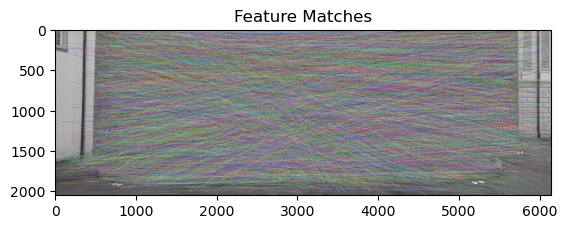

In [4]:
img1 = cv2.imread('data/fountain1.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/fountain2.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create(contrastThreshold=0.01)

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

print(f"Number of SIFT features in image 1: {len(keypoints1)}")
print(f"Number of SIFT features in image 2: {len(keypoints2)}")

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

print(f"Number of matches: {len(matches)}")

matched_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_img)
plt.title('Feature Matches')
plt.show()

x1 = np.array([keypoints1[m.queryIdx].pt for m in matches]).T
x2 = np.array([keypoints2[m.trainIdx].pt for m in matches]).T

In [5]:
x1_hom = np.vstack((x1, np.ones(x1.shape[1])))
x2_hom = np.vstack((x2, np.ones(x2.shape[1])))

inlier_threshold_px = 2
eps = inlier_threshold_px * 2 / (K[0, 0] + K[1, 1])
print(eps)
E, inliers = estimate_E_robust(x1_hom, x2_hom, K, eps)
print(E)
x1_inliers = x1[:, inliers]
x2_inliers = x2[:, inliers]


0.0007241601552599373
Number of inliers: 1757
[[ 0.00129121 -0.35493815  0.0392547 ]
 [-0.54225597 -0.04492283 -0.83879797]
 [ 0.02540359  0.93208967 -0.05829386]]


In [6]:
def extract_P_from_E(E):
    U, _, Vt = np.linalg.svd(E)
    
    if np.linalg.det(U @ Vt) < 0:
        Vt = -Vt

    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    P = [
        np.hstack((U @ W @ Vt, U[:, 2:3])),
        np.hstack((U @ W @ Vt, -U[:, 2:3])),
        np.hstack((U @ W.T @ Vt, U[:, 2:3])),
        np.hstack((U @ W.T @ Vt, -U[:, 2:3]))
    ]
    return P
def triangulate_3D_point_DLT(P1, P2, x1, x2):
    A = np.zeros((4, 4))
    
    A[0] = x1[0] * P1[2] - P1[0]
    A[1] = x1[1] * P1[2] - P1[1]
    A[2] = x2[0] * P2[2] - P2[0]
    A[3] = x2[1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1]  
    
    return X / X[-1]

def triangulate_all_points(P1, P2, x1, x2):
    X = np.zeros((4, x1.shape[1]))  

    for i in range(x1.shape[1]):
        X[:, i] = triangulate_3D_point_DLT(P1, P2, x1[:, i], x2[:, i])

    return X

def count_points_in_front(P, X):
    X_proj = P @ X 
    return np.sum(X_proj[2, :] > 0)


In [7]:
P1 = np.eye(3, 4)
P2s = extract_P_from_E(E)

max_points = -1
best_solution = None
un_norm_P1 = K @ P1
index = 0
p2s = []
Xs  = []

for i,P2 in enumerate(P2s):
    un_norm_P2 = K @ P2
    X = triangulate_all_points(un_norm_P1, un_norm_P2, x1_inliers, x2_inliers)
    count = count_points_in_front(un_norm_P1, X) + count_points_in_front(un_norm_P2, X)
    p2s.append(un_norm_P2)
    Xs.append(X)
    if count > max_points:
        index = i
        max_points = count
        best_solution = un_norm_P2
        best_X = X

print("Index:", index)
print("Best Camera Matrix (P2):", best_solution)

Index: 0
Best Camera Matrix (P2): [[ 2.85545025e+03 -2.16054809e+02 -1.31413551e+03  3.11981388e+03]
 [ 9.19762209e+02  2.76860694e+03  3.78285557e+02  4.11357277e+02]
 [ 8.06011282e-01  1.50387107e-02  5.91709092e-01  3.56602490e-01]]


In [8]:
%matplotlib qt

def plot_cams(P_list, ax):
    for P in P_list:
        c = null_space(P).flatten()
        c /= c[-1]
        v = P[2, :3]
        color = random.choice(["orange", "red", "green","blue"])
        ax.scatter(c[0], c[1], c[2], color=color, s=10, label="Camera Center")
        ax.quiver(c[0], c[1], c[2], v[0], v[1], v[2], color=color, length=0.2, linewidth=1.5, label="Principal Axis")
        
def plot_3d_points_and_cameras_with_principal_axes(Xmodel, P_list):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xmodel[0], Xmodel[1], Xmodel[2], color='green', s=1, label="3D Model Points")
    plot_cams(P_list, ax)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.axis('equal')

    ax.set_xlim([0, 5])
    ax.set_ylim([0, 5])
    ax.set_zlim([0, 5])
    
    plt.savefig('figs/CompEx2_3.png')
    plt.show()

P_list = [un_norm_P1,best_solution]
plot_3d_points_and_cameras_with_principal_axes(best_X, P_list)

In [9]:
for i in range(len(p2s)):
    a = [un_norm_P1, p2s[i]]
    b = Xs[i]
    plot_3d_points_and_cameras_with_principal_axes(b, a)